In [1]:
from module import decomposition
from module import dickey_fuller
from module import arima_endog
from module import arima_exog
from module import rmse_cv
from module import lasso_reg


import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import hstack
import warnings
import os
from fredapi import Fred
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from pmdarima import model_selection

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

%matplotlib inline
%load_ext autoreload
%autoreload

Using TensorFlow backend.


## STILL NEED TO UPDATE EXOGENOUS VARIABLES

### Set Datetime

In [2]:
start = datetime(2000,2,1)
end = datetime(2020,1,31)

## Gather Endogenous Data 

In [4]:
SUI = web.DataReader('SUI', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
SUI = SUI.copy()
SUI.index = pd.to_datetime(SUI.index)
SUI = SUI.resample('MS').mean()
SUI['mid'] = (SUI['high']+SUI['low'])/2
SUI.drop(labels = ['high', 'low', 'open', 'close', 'volume'], axis = 1, inplace = True)

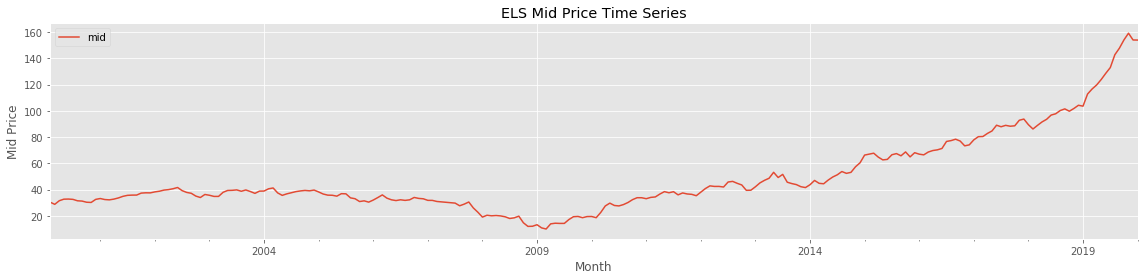

In [5]:
plt.style.use('ggplot')
SUI.plot(figsize = (16,4))
plt.xlabel('Month')
plt.ylabel('Mid Price')
plt.title('ELS Mid Price Time Series')
plt.tight_layout()
plt.show();

## Perform Decomposition of Time Series

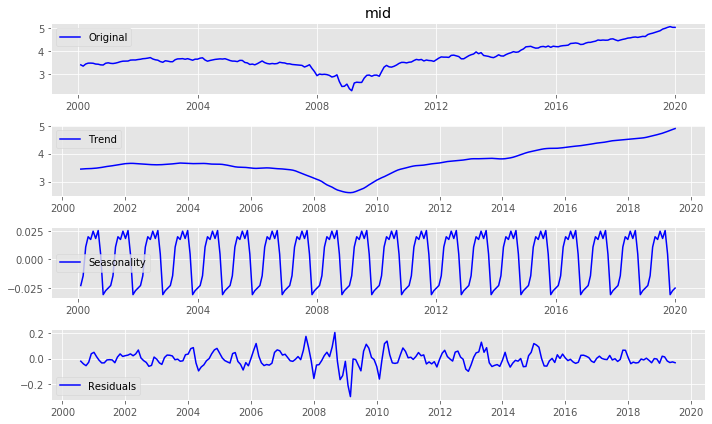

In [6]:
decomposition(SUI)

In [7]:
SUI_diff = SUI.diff(periods = 1).dropna()

In [8]:
dickey_fuller(SUI_diff)

The series passes the Dickey Fuller Test for Stationarity. P-Value = 1.820993407707167e-21


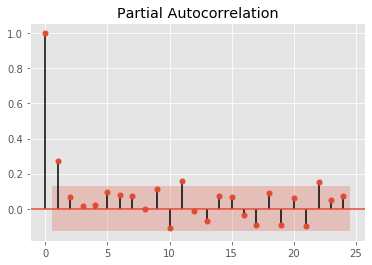

In [9]:
plot_pacf(SUI_diff);

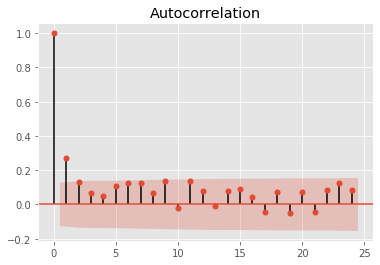

In [10]:
plot_acf(SUI_diff);

In [11]:
parameters = (3,1,3)
seasonal_parameters = (3,1,3,12)

## Train Test Split

In [12]:
SUI_train = SUI[:'2015']
SUI_test = SUI['2016':]

## SARIMAX Model (No Exogenous Variables)

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -296.404
Date:                            Fri, 07 Feb 2020   AIC                            620.808
Time:                                    19:06:29   BIC                            661.789
Sample:                                02-01-2000   HQIC                           637.462
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0029      0.006      0.510      0.610      -0.008       0.014
ar.L1         -0.5430     

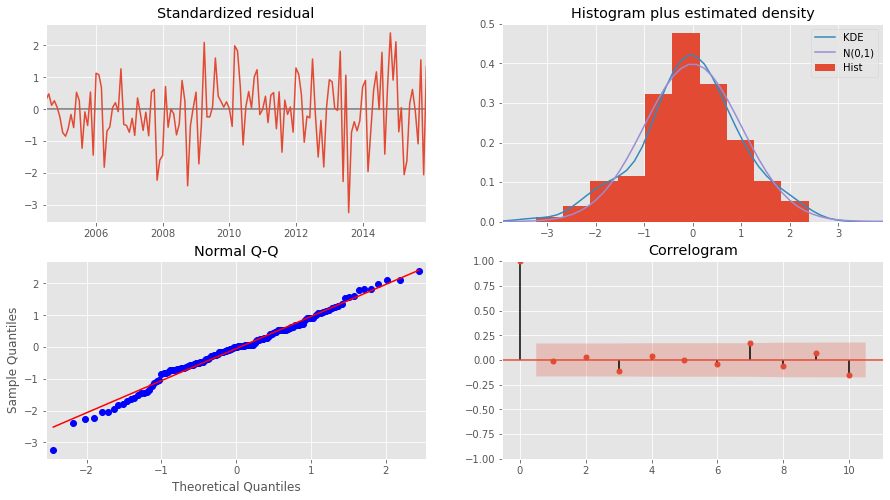

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


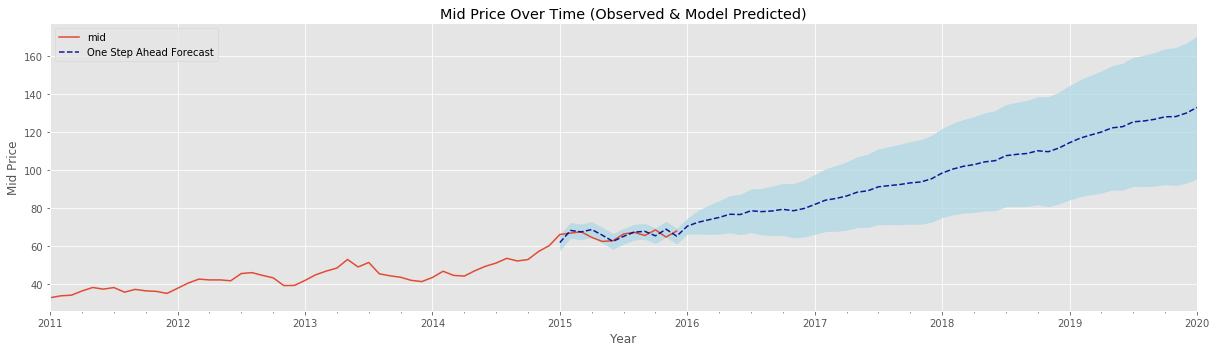

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Future Forecast: 
 


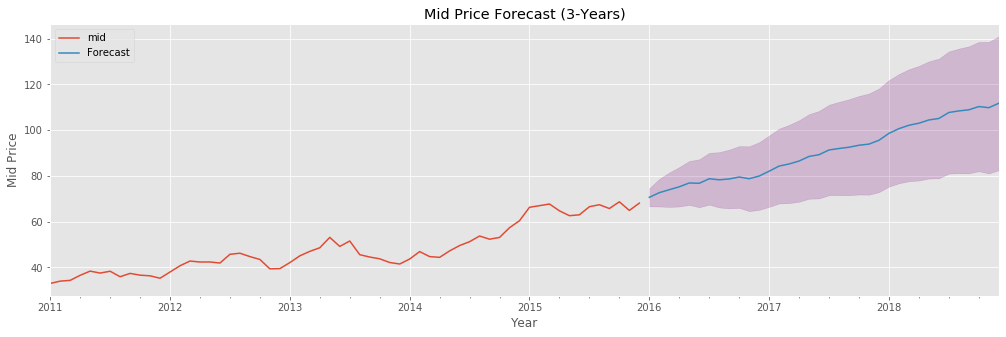

In [13]:
arima_endog(SUI_train, parameters, seasonal_parameters)

## Gather Exogenous Variables

In [14]:
SUI_rates = pd.read_csv('data/SUI_rates.csv', index_col = 'date')

### Train Test Split Exogenous Variables

### Perform Lasso Regression

The R-score of the Lasso Regression is: 0.9936958104570667

usd1mtd156n       -6.150674
mortgage30us      -6.380501
mortgage15us       1.752013
dcpf3m            -3.148918
cpn3m              4.131991
dcpf1m             2.672646
aaa                3.361874
baa               -3.957072
dff               -1.947832
flexsc            -0.524580
t10y2y             1.939846
t10y3m            -3.526480
tedrate           -7.173871
t10yff             0.000000
t5yff              4.620969
tb6smffm          -0.911583
usd3mtd156n        2.048170
usd12md156n       -3.695239
eur1wkd156n       -0.892843
mprime             6.780468
tb3ms             -2.496501
dtb6              -0.639512
dgs10             -0.604216
dgs3mo             0.764150
dexuseu            1.695915
dexchus            6.677753
dexusuk          -17.984581
dexsius            8.264256
nasdaqcom          0.004663
willreitind        0.007222
willlrgcap         0.001563
willsmlcap        -0.000635
vxdcls            -0.034243
stlfsi          

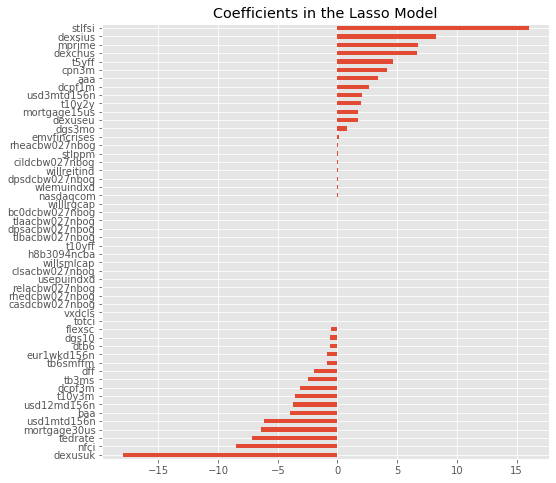

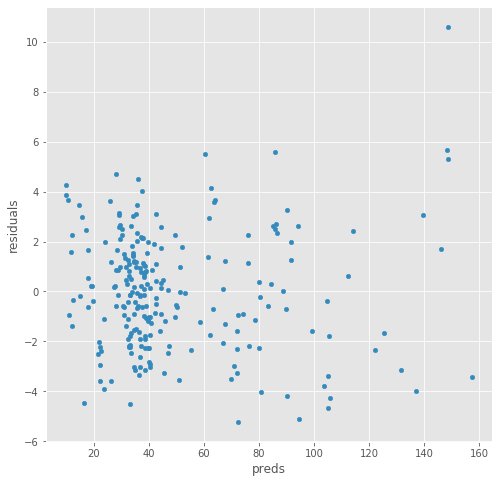

In [15]:
lasso_reg(SUI_rates)

### Select significant exogenous features from Lasso Regression

In [16]:
SUI_rates_train = SUI_rates[:'2016']
SUI_rates_test = SUI_rates['2016':]

In [17]:
exog_train = SUI_rates_train[['nasdaqcom', 'willreitind', 'willlrgcap', 'willsmlcap', 'vxdcls', 'h8b3094ncba', 'bc0dcbw027nbog', 'casdcbw027nbog', 'cildcbw027nbog',
                              'dpsdcbw027nbog', 'clsacbw027nbog', 'dpsacbw027nbog', 'relacbw027nbog', 'rheacbw027nbog', 'tlaacbw027nbog', 'tlbacbw027nbog', 'totci',
                              'usepuindxd', 'wlemuindxd']]

In [18]:
exog_test = SUI_rates_test[['nasdaqcom', 'willreitind', 'willlrgcap', 'willsmlcap', 'vxdcls', 'h8b3094ncba', 'bc0dcbw027nbog', 'casdcbw027nbog', 'cildcbw027nbog',
                              'dpsdcbw027nbog', 'clsacbw027nbog', 'dpsacbw027nbog', 'relacbw027nbog', 'rheacbw027nbog', 'tlaacbw027nbog', 'tlbacbw027nbog', 'totci',
                              'usepuindxd', 'wlemuindxd']]

In [21]:
exog_train.shape, exog_test.shape

((191, 19), (49, 19))

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -355.095
Date:                            Fri, 07 Feb 2020   AIC                            776.189
Time:                                    19:07:13   BIC                            872.788
Sample:                                02-01-2000   HQIC                           815.445
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
drift              0.0011      0.001      1.214      0.225      -0.001       0.003
nasdaqcom     

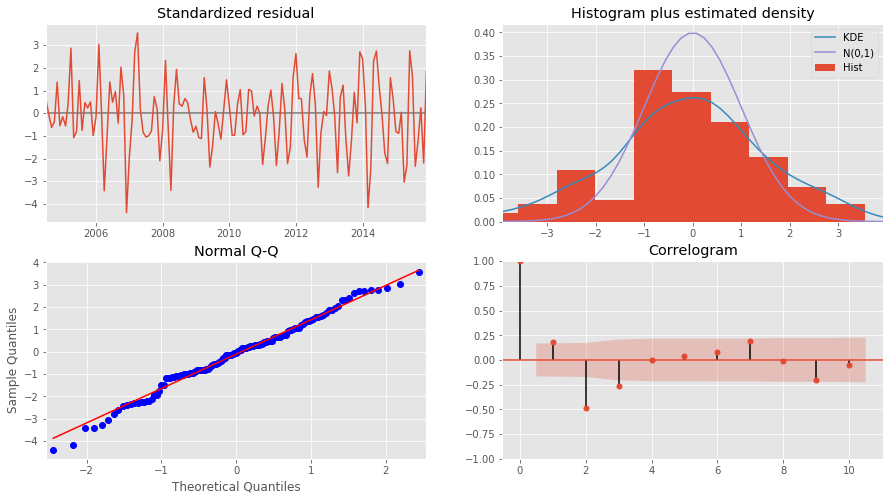

In [19]:
arima_model = sm.tsa.statespace.SARIMAX(SUI_train,
                                        exog = exog_train,
                                        order = parameters,
                                        seasonal_order = seasonal_parameters,
                                        enforce_stationarity = False,
                                        enforce_invertability = False,
                                        trend = 't')
results = arima_model.fit()
print(f'Summary: {results.summary()}')
print()
print('Diagnostics: ')
results.plot_diagnostics(figsize = (15,8))
plt.show()

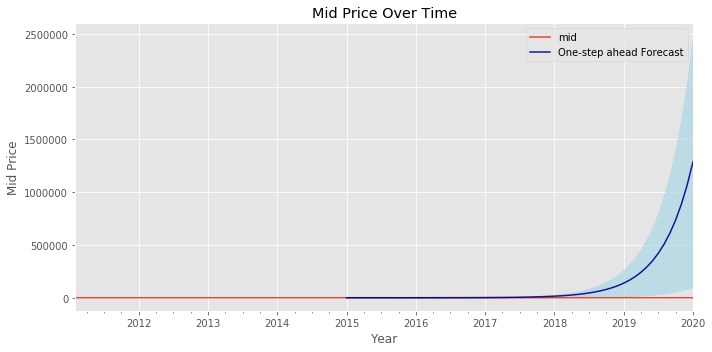

In [20]:
predictions = results.get_prediction(start = pd.to_datetime('2015-01-01'), end = pd.to_datetime('2020-01-01'), dynamic=True, exog = exog_test)
pred_conf = predictions.conf_int()
    
#Plot observed values
ax = SUI['2011-02-01':].plot(label='observed', figsize = (10,5))

#Plot predicted values
predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, color = 'darkblue')

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightblue', alpha=.7)

#Set axes labels
ax.set_xlabel('Year')
ax.set_ylabel('Mid Price')
plt.legend(loc = 'best')
plt.title(f'Mid Price Over Time')
plt.tight_layout()
plt.show()
    